In [ ]:
import torch
import torch.nn.functional as F
import os
import os.path
import shutil
import numpy as np
import soundfile as sf
import librosa as lr
import librosa.display as lrd
import matplotlib.pyplot as plt

from pathlib import PurePath
from torch import nn
from torch.utils.data import DataLoader, random_split
from asteroid.data import TimitDataset
from asteroid.data.utils import CachedWavSet, RandomMixtureSet, FixedMixtureSet
from asteroid_filterbanks.transforms import mag
from tqdm import tqdm
from einops import rearrange

from torch import optim
from pytorch_lightning import Trainer, seed_everything, loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from asteroid_filterbanks import make_enc_dec
from asteroid_filterbanks.transforms import mag
from asteroid.engine import System, GANSystem, UNetGAN
from asteroid.utils import unsqueeze_to_3d
from asteroid.utils.notebook_utils import show_wav
from asteroid.losses import singlesrc_neg_sisdr, singlesrc_mse

from asteroid import DCUNet, DCCRNet, DPRNNTasNet, ConvTasNet, RegressionFCNN, WaveUNet, Demucs, Phasen, SEGAN, MetricGAN

%load_ext autoreload
%autoreload 2

## Constants and utils

In [2]:
BATCH_SIZE       = 128    # could be more on cluster, test if larger one work
SAMPLE_RATE      = 8000   # as agreed upon
CROP_LEN         = 16384  # trying to train UNetGAN, so let's focus on that first
SEED             = 42     # magic number :)    

# directory with train noises (n116-n120)
DRONE_NOISE_DIR = '../../../datasets/noises/noises-train-drones'
# fixed SNRs for validation set
TRAIN_SNRS = [-25, -20, -15, -10, -5]

def sisdr_loss_wrapper(est_target, target):
    return singlesrc_neg_sisdr(est_target.squeeze(1), target).mean()

def train_val_split(ds, val_fraction=0.1, random_seed=SEED):
    assert val_fraction > 0 and val_fraction < 0.5
    len_train = int(len(ds) * (1 - val_fraction))
    len_val = len(ds) - len_train
    return random_split(ds, [len_train, len_val], generator=torch.Generator().manual_seed(random_seed))

def get_opt_and_sched(model, lr, lr_patience):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=lr_patience)
    return optimizer, scheduler

## Prepare the data

### Download and resample TIMIT dataset 

In [3]:
#TIMIT_DIR = PurePath('../../../datasets/TIMIT')
TIMIT_DIR_8kHZ = PurePath('../../../datasets/TIMIT')

### Load and split the data

In [4]:
%%time
# This is for training with on-the-fly random noise mixture with random SNR from the range.
# Is expected to produce a more robust result: checking this now on EECS server

# Reproducibility - fix all random seeds
seed_everything(SEED)

# Load noises, resample and save into the memory
noises = CachedWavSet(DRONE_NOISE_DIR, sample_rate=SAMPLE_RATE, precache=True)

# Load clean data and split it into train and val
timit = TimitDataset(TIMIT_DIR_8kHZ, subset='train', sample_rate=SAMPLE_RATE, with_path=False)
timit_train, timit_val = train_val_split(timit, val_fraction=0.1, random_seed=SEED)

# Training data mixes crops randomly on the fly with random SNR in range (effectively infinite training data)
# `repeat_factor=20` means that the dataset contains 20 copies of itself - it is the easiest way to make the epoch longer
timit_train = RandomMixtureSet(timit_train, noises, random_seed=SEED, snr_range=(-25, -5),
                               crop_length=CROP_LEN, repeat_factor=10)

# Validation data is fixed (for stability): mix every clean clip with all the noises in the folder
# Argument `mixtures_per_clean` regulates with how many different noise files each clean file will be mixed
timit_val = FixedMixtureSet(timit_val, noises, snrs=TRAIN_SNRS, random_seed=SEED,
                            mixtures_per_clean=5, crop_length=CROP_LEN)

Global seed set to 42
Precaching audio: 100%|██████████| 5/5 [00:00<00:00, 412.59it/s]

CPU times: user 95.9 ms, sys: 11.1 ms, total: 107 ms
Wall time: 106 ms


In [5]:
# Reproducibility - fix all random seeds
# seed_everything(SEED)

# # Load noises, resample and save into the memory
# noises = CachedWavSet(DRONE_NOISE_DIR, sample_rate=SAMPLE_RATE, precache=True)

# timit = TimitDataset(TIMIT_DIR_8kHZ, subset='train', sample_rate=SAMPLE_RATE, with_path=False)
# timit_mix = FixedMixtureSet(timit, noises, snrs=TRAIN_SNRS, random_seed=SEED,
#                             mixtures_per_clean=5, crop_length=CROP_LEN)

# timit_train, timit_val = train_val_split(timit_mix, val_fraction=0.1, random_seed=SEED)

In [6]:
NUM_WORKERS = 10
PREFETCH = 20
train_loader = DataLoader(timit_train, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True,
                          num_workers=NUM_WORKERS, prefetch_factor=PREFETCH, drop_last=True)
val_loader = DataLoader(timit_val, batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS, prefetch_factor=PREFETCH, drop_last=True)

## test segan training

In [7]:
segan = SEGAN()

In [8]:
LR = 2e-4
adv_loss = F.mse_loss
reg_loss = F.l1_loss

opt_G = optim.RMSprop(segan.generator.parameters(), lr=LR)
opt_D = optim.RMSprop(segan.discriminator.parameters(), lr=LR)

system = GANSystem.load_from_checkpoint(
    '../../../workspace/logs/SEGAN/version_0/checkpoints/epoch=121-step=19763.ckpt',
    model=segan, optimizers=[opt_G, opt_D], 
    adv_loss=adv_loss, reg_loss=reg_loss,
    reg_weight=100,
    train_loader=train_loader,
    val_loader=val_loader)

In [9]:
LOG_DIR = '../../../workspace/logs'

logger = pl_loggers.TensorBoardLogger(LOG_DIR, name='SEGAN', version=1)
trainer = Trainer(max_epochs=150, gpus=1, accelerator='dp',
                  logger=logger, deterministic=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [11]:
trainer.fit(system)


  | Name  | Type      | Params
------------------------------------
0 | model | Generator | 73.1 M
------------------------------------
73.1 M    Trainable params
1.5 K     Non-trainable params
73.1 M    Total params
292.406   Total estimated model params size (MB)


                                                              hi cuda:2
hj cuda:1
sk_h cuda:1
hi cuda:0
hj cuda:1
hi cuda:1
hj cuda:1
sk_h cuda:1
sk_h cuda:1
hi cuda:1
hj cuda:1
sk_h cuda:1
hi cuda:1
hj cuda:1
sk_h cuda:1
hi cuda:1
hj cuda:1
sk_h cuda:1
hi cuda:1
hj cuda:1
sk_h cuda:1
hi cuda:1
hj cuda:1
sk_h cuda:1
hi cuda:1
hj cuda:1
sk_h cuda:1
hi cuda:1
hj cuda:1
sk_h cuda:1
hi cuda:1
hj cuda:1
sk_h cuda:1
hi cuda:1
hj cuda:1
sk_h cuda:1


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/site-packages/pytorch_lightning/overrides/data_parallel.py", line 74, in forward
    output = super().forward(*inputs, **kwargs)
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/site-packages/pytorch_lightning/overrides/base.py", line 63, in forward
    output = self.module.validation_step(*inputs, **kwargs)
  File "/home/flyingleafe/projects/asteroid/asteroid/engine/system.py", line 133, in validation_step
    loss = self.common_step(batch, batch_nb, train=False)
  File "/home/flyingleafe/projects/asteroid/asteroid/engine/system.py", line 104, in common_step
    est_targets = self(inputs)
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/flyingleafe/projects/asteroid/asteroid/engine/system.py", line 74, in forward
    return self.model(*args, **kwargs)
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/flyingleafe/projects/asteroid/asteroid/models/segan.py", line 297, in forward
    hi = skip_conn['alpha'](skip_conn['tensor'], hi)
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/flyingleafe/projects/asteroid/asteroid/models/segan.py", line 153, in forward
    return torch.cat((hi, sk_h), dim=1)
RuntimeError: All input tensors must be on the same device. Received cuda:0 and cuda:1


In [15]:
torch.save(segan.serialize(), '../../../workspace/models/SEGAN.pt')

### segan training (generator only, L1 loss)

In [8]:
segan = SEGAN(no_z=True)

LR = 1e-3
REDUCE_LR_PATIENCE = 5
EARLY_STOP_PATIENCE = 10
LOSS_THRESHOLD = 1e-6
MAX_EPOCHS = 100

optimizer, scheduler = get_opt_and_sched(segan.generator, LR, REDUCE_LR_PATIENCE)
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, min_delta=LOSS_THRESHOLD)

system = System(segan.generator, optimizer, F.l1_loss, train_loader, val_loader, scheduler)

LOG_DIR = '../../../workspace/logs'

logger = pl_loggers.TensorBoardLogger(LOG_DIR, name='SEGAN-gen-only', version='no_z')
trainer = Trainer(max_epochs=MAX_EPOCHS, gpus=-1, accelerator='dp',
                  logger=logger, callbacks=[early_stopping], deterministic=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [9]:
trainer.fit(system)


  | Name  | Type      | Params
------------------------------------
0 | model | Generator | 56.8 M
------------------------------------
56.8 M    Trainable params
1.5 K     Non-trainable params
56.8 M    Total params
227.394   Total estimated model params size (MB)


Validation sanity check:  50%|█████     | 1/2 [00:03<00:03,  3.53s/it]

/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Your validation_step returned None. Did you forget to return an output?
  warnings.warn(*args, **kwargs)


Epoch 0:  78%|███████▊  | 162/207 [01:44<00:28,  1.55it/s, loss=0.00848, v_num=no_z, val_loss=0.150]
Validating: 0it [00:00, ?it/s]
Epoch 1:  78%|███████▊  | 162/207 [01:43<00:28,  1.56it/s, loss=0.00805, v_num=no_z, val_loss=0.00837]
Validating: 0it [00:00, ?it/s]
Epoch 2:  78%|███████▊  | 162/207 [01:43<00:28,  1.56it/s, loss=0.00791, v_num=no_z, val_loss=0.00789]
Validating: 0it [00:00, ?it/s]
Epoch 3:  78%|███████▊  | 162/207 [01:43<00:28,  1.56it/s, loss=0.00799, v_num=no_z, val_loss=0.00785]
Validating: 0it [00:00, ?it/s]
Epoch 4:  78%|███████▊  | 162/207 [01:44<00:28,  1.55it/s, loss=0.00789, v_num=no_z, val_loss=0.00779]
Validating: 0it [00:00, ?it/s]
Epoch 5:  78%|███████▊  | 162/207 [01:45<00:29,  1.54it/s, loss=0.00806, v_num=no_z, val_loss=0.00778]
Validating: 0it [00:00, ?it/s]
Epoch 6:  78%|███████▊  | 162/207 [01:44<00:28,  1.55it/s, loss=0.00787, v_num=no_z, val_loss=0.00784]
Validating: 0it [00:00, ?it/s]
Epoch 7:  78%|███████▊  | 162/207 [01:44<00:29,  1.55it/s, loss=

/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


KeyboardInterrupt: 

In [12]:
segan(torch.randn(1, 1, 16384).cuda())

tensor([[[ 1., -1.,  1.,  ..., -1.,  1., -1.]]], device='cuda:0',
       grad_fn=<ConstantPadNdBackward>)

In [ ]:
state_dict = segan.generator

In [ ]:
torch.save(segan.serialize(), '../../../workspace/models/SEGAN-gen-only-no-z.pt')

Epoch 17:  71%|███████▏  | 148/207 [01:50<00:43,  1.34it/s, loss=1, v_num=no_z, val_loss=1.000]

In [21]:
random_wav = torch.randn(1,1, 16384)
random_wav.shape

torch.Size([1, 1, 16384])

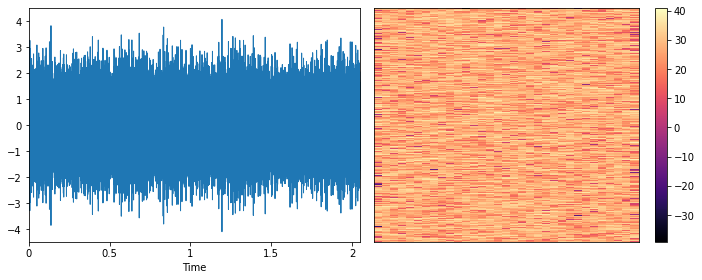

In [22]:
show_wav(random_wav.flatten())

In [23]:
segan_out = segan.generator(random_wav.cuda())

In [26]:
segan_out.shape

torch.Size([1, 1, 16384])

## test MetricGAN training

In [7]:
metric_gan = MetricGAN()

In [8]:
LR = 2e-4
adv_loss = F.mse_loss
reg_loss = F.l1_loss

opt_G = optim.Adam(metric_gan.generator.parameters(), lr=LR)
opt_D = optim.Adam(metric_gan.discriminator.parameters(), lr=LR)

system = GANSystem(metric_gan, [opt_G, opt_D], 
    adv_loss=adv_loss, reg_loss=reg_loss,
    reg_weight=100,
    train_loader=train_loader,
    val_loader=val_loader)

In [9]:
LOG_DIR = '../../../workspace/logs'

logger = pl_loggers.TensorBoardLogger(LOG_DIR, name='MetricGAN', version=0)
trainer = Trainer(max_epochs=150, gpus=[0], accelerator='dp', logger=logger, deterministic=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [ ]:
trainer.fit(system)


  | Name  | Type      | Params
------------------------------------
0 | model | MetricGAN | 3.8 M 
------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.225    Total estimated model params size (MB)


Epoch 0:   3%|▎         | 12/414 [01:19<44:06,  6.58s/it, v_num=0, val_g_loss=6.93e+8, val_d_loss=1.22e+9, d_loss=0.475, g_loss=1.550]

### test phasen training

In [7]:
LR = 1e-3
REDUCE_LR_PATIENCE = 3
EARLY_STOP_PATIENCE = 5
LOSS_THRESHOLD = 1e-6
MAX_EPOCHS = 100


class PhasenSystem(System):
    def common_step(self, batch, batch_nb, train=True):
        mix, clean = batch
        mix = unsqueeze_to_3d(mix)
        clean = unsqueeze_to_3d(clean)
        
        mix_tf = self.model.forward_encoder(mix)
        clean_tf = self.model.forward_encoder(clean)
        est_masks = self.model.forward_masker(mix_tf)
        est_tf = self.model.apply_masks(mix_tf, est_masks)
        
        print('mix', mix_tf.shape)
        print('ests', est_tf.shape)
        
        return self.loss_func(est_tf, clean_tf)


def phasen_loss_wrapper(est_target, target):
    est_mag = mag(est_target)
    true_mag = mag(target)
    est_mag_comp = est_mag**0.3
    true_mag_comp = true_mag**0.3
    
    mag_loss = F.mse_loss(est_mag_comp, true_mag_comp)

    # scale the complex spectrograms' magniture to the power 0.3 as well
    true_comp_coeffs = (true_mag_comp/(1e-8+true_mag)).repeat(1,2,1)
    est_comp_coeffs = (est_mag_comp/(1e-8+est_mag)).repeat(1,2,1)
    phase_loss = F.mse_loss(est_target * est_comp_coeffs, target * true_comp_coeffs)
    
    return (mag_loss + phase_loss) / 2


phasen = Phasen()

optimizer, scheduler = get_opt_and_sched(phasen, LR, REDUCE_LR_PATIENCE)
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, min_delta=LOSS_THRESHOLD)
loss = phasen_loss_wrapper

system = PhasenSystem(phasen, optimizer, loss, train_loader, val_loader, scheduler)

In [8]:
LOG_DIR = '../../../workspace/logs'

logger = pl_loggers.TensorBoardLogger(LOG_DIR, name='Phasen-test', version=0)

trainer = Trainer(max_epochs=MAX_EPOCHS, #gpus=-1, accelerator='dp',
                  logger=logger, callbacks=[early_stopping], deterministic=True, fast_dev_run=True)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).


In [9]:
trainer.fit(system)


  | Name  | Type   | Params
---------------------------------
0 | model | Phasen | 8.8 M 
---------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.100    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] mix torch.Size([32, 514, 237])
ests torch.Size([32, 514, 237])
Epoch 0:  50%|█████     | 1/2 [01:01<01:01, 61.30s/it, loss=0.0258]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/1 [00:00<?, ?it/s]mix torch.Size([32, 514, 237])
ests torch.Size([32, 514, 237])

Epoch 0: 100%|██████████| 2/2 [01:19<00:00, 39.77s/it, loss=0.0258, val_loss=0.0492]


1

## Set up the model, optimizer and scheduler

In [7]:
LR = 5e-4
REDUCE_LR_PATIENCE = 3
EARLY_STOP_PATIENCE = 5
LOSS_THRESHOLD = 1e-6
MAX_EPOCHS = 100

# the model here should be constructed in the script accordingly to the passed config (including the model type)
# most of the models accept `sample_rate` parameter for encoders, which is important (default is 16000, override)
#model = DCUNet("DCUNet-20", fix_length_mode="trim", sample_rate=SAMPLE_RATE)
#model = DCCRNet("DCCRN-CL", sample_rate=SAMPLE_RATE)
unetgan_ckp = UNetGAN.load_from_checkpoint(
    '../../../workspace/logs/UNetGAN-pretrained-gen/version_5/checkpoints/last.ckpt', disc_concat_type='time')
loss = F.mse_loss

unetgan = UNetGAN(training_phase=1, disc_concat_type='channels')
unetgan.generator = unetgan_ckp.generator
#unetgan.discriminator = unetgan_ckp.discriminator

# Glorot initialization of the model's parameters (important, mentioned in the paper)
# lrelu_gain = nn.init.calculate_gain('leaky_relu', 0.01)
# def init_weights(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.xavier_normal_(m.weight, gain=lrelu_gain)
#         if m.bias is not None:
#             m.bias.data.fill_(0.01)
    
# model = model.apply(init_weights)

## Train the generator with MSE loss separately first

In [8]:
class FixDimSystem(System):
    def common_step(self, batch, batch_nb, train=True):
        inputs, targets = batch
        inputs = unsqueeze_to_3d(inputs)
        targets = unsqueeze_to_3d(targets)
        
        est_targets = self(inputs)
        loss = self.loss_func(est_targets, targets)
        return loss

In [9]:
optimizer, scheduler = get_opt_and_sched(unetgan.generator, LR, REDUCE_LR_PATIENCE)
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, min_delta=LOSS_THRESHOLD)
checkpoint = ModelCheckpoint(
    filename='{epoch:02d}-{val_loss:.2f}',
    monitor="val_loss",
    mode="min",
    save_top_k=5
)

# Probably we also need to subclass `System`, in order to log the target metrics on the validation set (PESQ/STOI)
#system = FixDimSystem(unetgan.generator, optimizer, loss, train_loader, val_loader, scheduler)
system = FixDimSystem.load_from_checkpoint(
    '../../../workspace/logs/UNetGAN-generator-pretrain/version_3/checkpoints/epoch=07-val_loss=0.00.ckpt',
    model=unetgan.generator, optimizer=optimizer, loss_func=loss,
    train_loader=train_loader, val_loader=val_loader, scheduler=scheduler)

In [8]:
LOG_DIR = '../../../workspace/logs'

In [11]:
logger = pl_loggers.TensorBoardLogger(LOG_DIR, name='UNetGAN-generator-pretrain', version=3)

trainer = Trainer(max_epochs=300, gpus=-1, accelerator='dp',
                  logger=logger, callbacks=[early_stopping, checkpoint], deterministic=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [19]:
trainer.fit(system)


  | Name  | Type             | Params
-------------------------------------------
0 | model | UNetGANGenerator | 3.0 M 
-------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
12.185    Total estimated model params size (MB)


Epoch 0:  78%|███████▊  | 162/207 [02:16<00:37,  1.18it/s, loss=6.99e-05, v_num=3, val_loss=0.000156]
Validating: 0it [00:00, ?it/s]
Epoch 1:  78%|███████▊  | 162/207 [02:14<00:37,  1.20it/s, loss=6.92e-05, v_num=3, val_loss=6.81e-5]
Validating: 0it [00:00, ?it/s]
Epoch 2:  78%|███████▊  | 162/207 [02:14<00:37,  1.20it/s, loss=6.91e-05, v_num=3, val_loss=7.72e-5]
Validating: 0it [00:00, ?it/s]
Epoch 3:  78%|███████▊  | 162/207 [02:14<00:37,  1.20it/s, loss=6.79e-05, v_num=3, val_loss=7.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 4:  78%|███████▊  | 162/207 [02:14<00:37,  1.20it/s, loss=6.74e-05, v_num=3, val_loss=7.15e-5]
Validating: 0it [00:00, ?it/s]
Epoch 5:  78%|███████▊  | 162/207 [02:15<00:37,  1.20it/s, loss=6.64e-05, v_num=3, val_loss=6.62e-5]
Validating: 0it [00:00, ?it/s]
Epoch 6:  78%|███████▊  | 162/207 [02:14<00:37,  1.20it/s, loss=6.73e-05, v_num=3, val_loss=7.45e-5]
Validating: 0it [00:00, ?it/s]
Epoch 7:  78%|███████▊  | 162/207 [02:15<00:37,  1.20it/s, loss=6.82e-05, v_

1

In [9]:
checkpoint = ModelCheckpoint(
    filename='{epoch:02d}-{val_loss:.2f}',
    monitor="val_g_loss",
    mode="min",
    save_top_k=5,
    save_last=True,
)
logger2 = pl_loggers.TensorBoardLogger(LOG_DIR, name='UNetGAN-pretrained-gen', version=6)
trainer2 = Trainer(max_epochs=300, gpus=1, accelerator='dp',
                   logger=logger2, callbacks=[checkpoint], deterministic=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


## Enhance further using GAN training

In [ ]:
trainer2.fit(unetgan, train_loader, val_loader)


  | Name          | Type                 | Params
-------------------------------------------------------
0 | generator     | UNetGANGenerator     | 3.0 M 
1 | discriminator | UNetGANDiscriminator | 619 K 
-------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.665    Total estimated model params size (MB)


Epoch 0:  78%|███████▊  | 649/829 [07:46<02:09,  1.39it/s, v_num=6, val_g_loss=0.710, val_d_loss=0.693, d_loss=0.000908, g_loss=0.00312]
Validating: 0it [00:00, ?it/s]
Epoch 1:  78%|███████▊  | 650/829 [07:41<02:07,  1.41it/s, v_num=6, val_g_loss=27.90, val_d_loss=0.0003, d_loss=0.00576, g_loss=0.0149]  
Validating: 0it [00:00, ?it/s]
Epoch 2:  78%|███████▊  | 650/829 [07:39<02:06,  1.41it/s, v_num=6, val_g_loss=15.20, val_d_loss=0.00993, d_loss=7.55e-5, g_loss=0.0149] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  78%|███████▊  | 650/829 [07:47<02:08,  1.39it/s, v_num=6, val_g_loss=18.30, val_d_loss=9.94e-5, d_loss=5.07e-5, g_loss=0.00877]
Validating: 0it [00:00, ?it/s]
Epoch 4:  78%|███████▊  | 650/829 [07:41<02:07,  1.41it/s, v_num=6, val_g_loss=0.0107, val_d_loss=5.710, d_loss=0.00767, g_loss=0.0063] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  78%|███████▊  | 650/829 [07:39<02:06,  1.41it/s, v_num=6, val_g_loss=18.00, val_d_loss=0.00104, d_loss=8.22e-5, g_loss=1.640]  
Validating: 0it [00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 34:  78%|███████▊  | 650/829 [07:59<02:12,  1.36it/s, v_num=6, val_g_loss=1.850, val_d_loss=3.730, d_loss=8.22e-5, g_loss=1.610]
Validating: 0it [00:00, ?it/s]
Epoch 35:  78%|███████▊  | 650/829 [08:00<02:12,  1.35it/s, v_num=6, val_g_loss=2.340, val_d_loss=2.570, d_loss=8.22e-5, g_loss=3.080]
Validating: 0it [00:00, ?it/s]
Epoch 36:  78%|███████▊  | 650/829 [09:07<02:30,  1.19it/s, v_num=6, val_g_loss=3.880, val_d_loss=3.020, d_loss=8.22e-5, g_loss=3.010]
Validating: 0it [00:00, ?it/s]
Epoch 37:  78%|███████▊  | 650/829 [08:03<02:13,  1.35it/s, v_num=6, val_g_loss=7.000, val_d_loss=5.910, d_loss=8.22e-5, g_loss=1.590]
Validating: 0it [00:00, ?it/s]
Epoch 38:  42%|████▏     | 346/829 [04:17<05:59,  1.34it/s, v_num=6, val_g_loss=2.240, val_d_loss=3.310, d_loss=8.22e-5, g_loss=1.600]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 39:  78%|███████▊  | 650/829 [08:02<02:12,  1.35it/s, v_num=6, val_g_loss=1.950, val_d_loss=6.810, d_loss=8.22e-5, g_loss=1.580]
Validating: 0it [00:00, ?it/s]
Epoch 40:  78%|███████▊  | 650/829 [07:59<02:12,  1.36it/s, v_num=6, val_g_loss=2.850, val_d_loss=3.570, d_loss=8.22e-5, g_loss=1.650]
Validating: 0it [00:00, ?it/s]
Epoch 41:  78%|███████▊  | 650/829 [08:01<02:12,  1.35it/s, v_num=6, val_g_loss=2.200, val_d_loss=8.060, d_loss=8.22e-5, g_loss=1.600]
Validating: 0it [00:00, ?it/s]
Epoch 42:  78%|███████▊  | 650/829 [08:01<02:12,  1.35it/s, v_num=6, val_g_loss=1.340, val_d_loss=5.190, d_loss=8.22e-5, g_loss=1.570]
Validating: 0it [00:00, ?it/s]
Epoch 43:  78%|███████▊  | 650/829 [08:00<02:12,  1.35it/s, v_num=6, val_g_loss=1.750, val_d_loss=4.420, d_loss=8.22e-5, g_loss=0.500]
Validating: 0it [00:00, ?it/s]
Epoch 44:  44%|████▍     | 368/829 [04:32<05:41,  1.35it/s, v_num=6, val_g_loss=2.290, val_d_loss=4.010, d_loss=8.22e-5, g_loss=1.110]